In [1]:
import mne
import numpy as np
from matplotlib import pyplot as plt
import math
from scipy import stats, signal
import itertools
import pandas as pd
from datetime import datetime

Extracting EDF parameters from C:\Lilach\402_for_tag.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


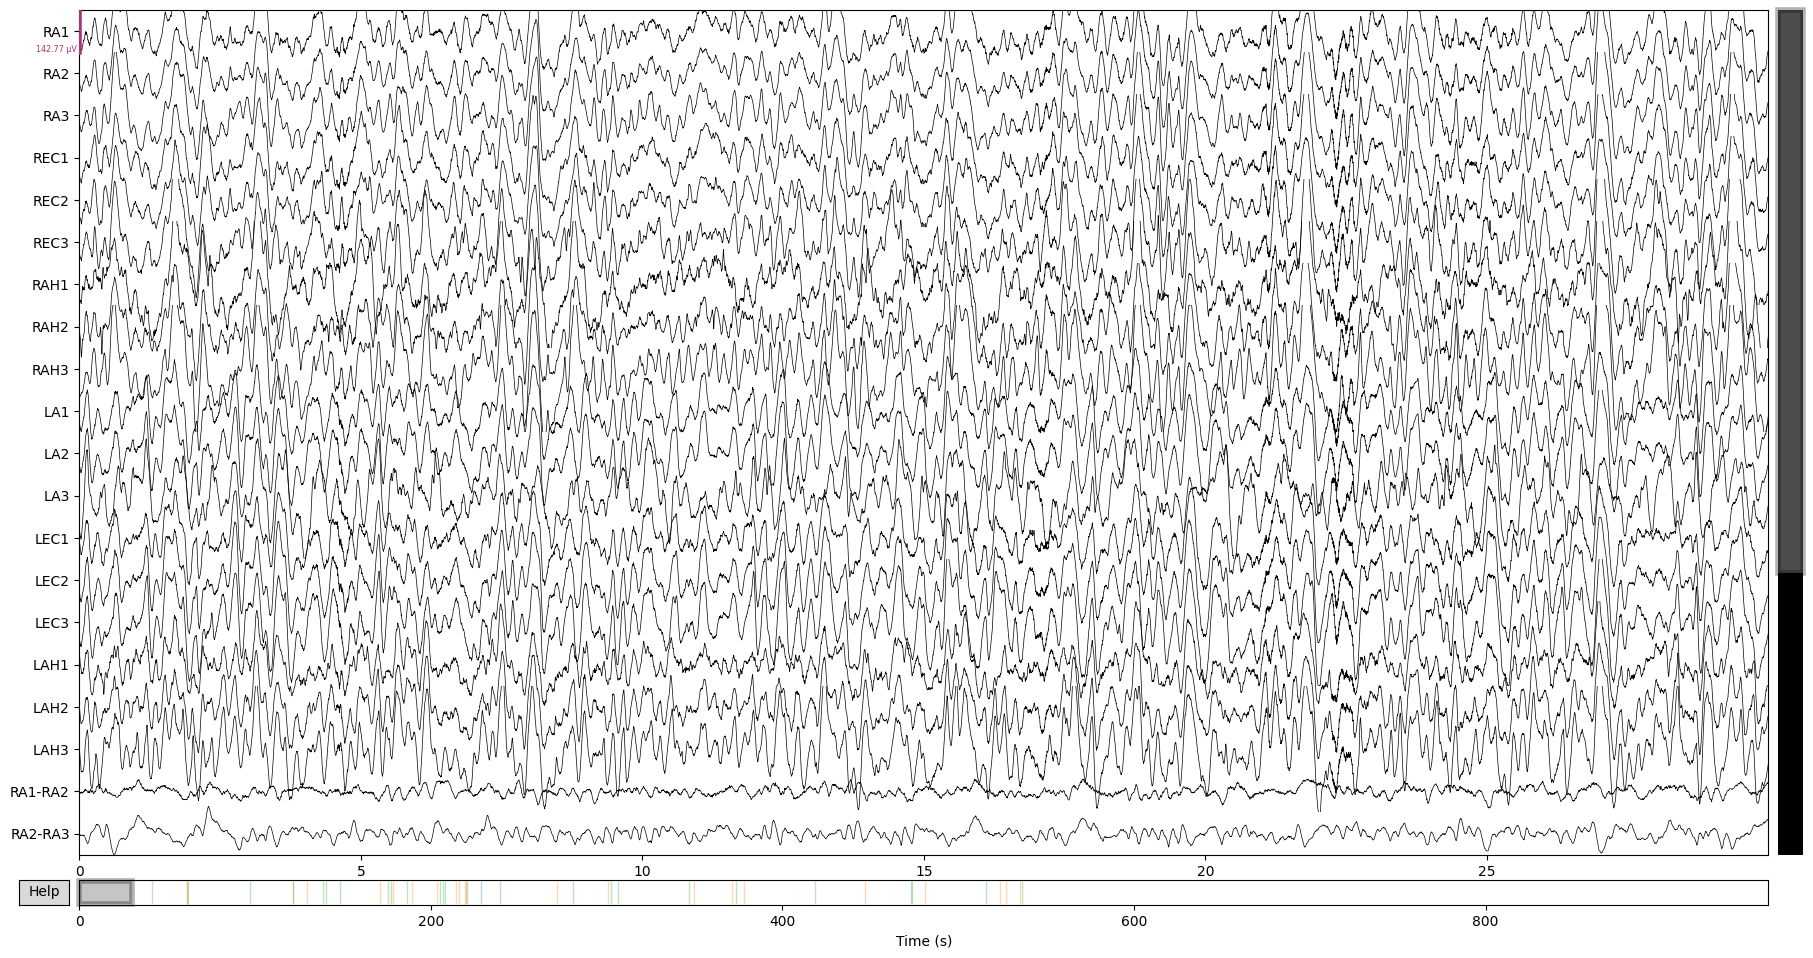

Channels marked as bad: none


In [2]:
%matplotlib qt
raw = mne.io.read_raw_edf('C:\\Lilach\\402_for_tag.edf')
raw.plot(duration=30, scalings='auto')

In [11]:
for x in raw.annotations:
    print(x)

OrderedDict([('onset', 41.1777), ('duration', 0.0), ('description', 'Rt spike'), ('orig_time', datetime.datetime(2007, 9, 23, 23, 30, tzinfo=datetime.timezone.utc))])
OrderedDict([('onset', 61.0798), ('duration', 0.0), ('description', 'Lt spike'), ('orig_time', datetime.datetime(2007, 9, 23, 23, 30, tzinfo=datetime.timezone.utc))])
OrderedDict([('onset', 61.1191), ('duration', 0.0), ('description', 'Lt spike'), ('orig_time', datetime.datetime(2007, 9, 23, 23, 30, tzinfo=datetime.timezone.utc))])
OrderedDict([('onset', 61.8968), ('duration', 0.0), ('description', 'Rt spike'), ('orig_time', datetime.datetime(2007, 9, 23, 23, 30, tzinfo=datetime.timezone.utc))])
OrderedDict([('onset', 97.1905), ('duration', 0.0), ('description', 'Rt spike'), ('orig_time', datetime.datetime(2007, 9, 23, 23, 30, tzinfo=datetime.timezone.utc))])
OrderedDict([('onset', 121.2242), ('duration', 0.0), ('description', 'Lt spike'), ('orig_time', datetime.datetime(2007, 9, 23, 23, 30, tzinfo=datetime.timezone.utc))

In [12]:
# raw.annotations.save('C:\\Lilach\\402_anot.csv')

In [14]:
# Get tags from annotations (only until the 'end' cause it's 100% covered)
df = pd.DataFrame(raw.annotations)
i = df.loc[df['description'] == 'END'].index[0]
df = df[:i]
right = df[df['description'].str.contains('Rt')]
left = df[df['description'].str.contains('Lt')]

In [26]:
right

,onset,duration,description,orig_time
0,41.1777,0.0,Rt spike,2007-09-23 23:30:00+00:00
3,61.8968,0.0,Rt spike,2007-09-23 23:30:00+00:00
4,97.1905,0.0,Rt spike,2007-09-23 23:30:00+00:00
6,121.4411,0.0,Rt spike,2007-09-23 23:30:00+00:00
8,138.4960,0.0,Rt spike,2007-09-23 23:30:00+00:00
9,140.2353,0.0,Rt spike,2007-09-23 23:30:00+00:00
10,148.1345,0.0,Rt spike,2007-09-23 23:30:00+00:00
12,175.7111,0.0,Rt spike,2007-09-23 23:30:00+00:00
13,177.1841,0.0,Rt spike,2007-09-23 23:30:00+00:00
15,186.5143,0.0,Rt spike,2007-09-23 23:30:00+00:00


In [27]:
left

,onset,duration,description,orig_time
1,61.0798,0.0,Lt spike,2007-09-23 23:30:00+00:00
2,61.1191,0.0,Lt spike,2007-09-23 23:30:00+00:00
5,121.2242,0.0,Lt spike,2007-09-23 23:30:00+00:00
7,129.6388,0.0,Lt spike,2007-09-23 23:30:00+00:00
11,170.9425,0.0,Lt spike,2007-09-23 23:30:00+00:00
14,178.2380,0.0,Lt spike,2007-09-23 23:30:00+00:00
16,189.1740,0.0,Lt spike,2007-09-23 23:30:00+00:00
17,203.2261,0.0,Lt spike,2007-09-23 23:30:00+00:00
21,214.4245,0.0,Lt spike,2007-09-23 23:30:00+00:00
22,215.6745,0.0,Lt spike,2007-09-23 23:30:00+00:00
